In [84]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from matplotlib import pyplot as plt

## 3. Логистическая регрессия. Реализация

Функция ошибки для логистической регрессии в случае бинарной классификации называется бинарной кросс-энтропией и записывается следующим образом:
$$L=-\frac{1}{n}(y_i \log h_{\theta}(x_i) + (1-y_i) \log(1-h_{\theta}(x_i))),$$
где $x_i$ — вектор признаков $i$-го примера из обучающей выборки, $y_i$ — истинный класс для соответствующего примера (0 или 1), $n$ — число примеров в обучающей выборке, $h_{\theta}(x)$ — sigmoid функция, равная:
$$h_{\theta}(x)=\frac{1}{1+\exp^{-\theta x}},$$
где $\theta$ — вектор параметров логистической регрессии, $x$ - вектор признаков объекта из выборки.

Соответствующий градиент функции ошибки равен:
$$\nabla L=\frac{1}{n}\sum_{i=1}^{n}{(h_{\theta}(x_i)-y_i)x_i}$$

Реализация логистической регрессии будет основана на оптимизации функции ошибки градиентным спуском.

В качестве экспериментальных данных возьмем датасет о доходах граждан в различных странах [Adult Income](https://archive.ics.uci.edu/ml/datasets/Adult) и сделаем необходимую предобработку.

In [85]:
adult = pd.read_csv('./data/adult.data',
                    names=['age', 'workclass', 'fnlwgt', 'education',
                           'education-num', 'marital-status', 'occupation',
                           'relationship', 'race', 'sex', 'capital-gain',
                           'capital-loss', 'hours-per-week', 'native-country', 'salary'])

In [29]:
# Описание датасета

# with open('./data/adult.names', 'r') as f:
#     names = f.read()
# print(names)

In [30]:
adult.head(2)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K


In [31]:
tops = [x for x, y in adult['native-country'].value_counts().items() if y >= 100]
def hgf(x):
    if x in tops:
        return x
    else:
        return ' other'

In [86]:
# Избавиться от лишних признаков
adult.drop(['native-country'], axis=1, inplace=True)

# adult['native-country'].apply(hgf)
# Сконвертировать целевой столбец в бинарные значения
adult['salary'] = (adult['salary'] != ' <=50K').astype('int32')
# Сделать one-hot encoding для некоторых признаков
adult = pd.get_dummies(adult, columns=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex'])

In [33]:
adult.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,salary,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,...,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0


In [87]:
# Нормализовать нуждающиеся в этом признаки
a_features = adult[['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']].values
norm_features = (a_features - a_features.mean(axis=0)) / a_features.std(axis=0)
adult.loc[:, ['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']] = norm_features

In [35]:
adult.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,salary,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,...,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male
0,0.030671,-1.063611,1.134739,0.148453,-0.21666,-0.035429,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,0.837109,-1.008707,1.134739,-0.145920,-0.21666,-2.222153,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,-0.042642,0.245079,-0.420060,-0.145920,-0.21666,-0.035429,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,1.057047,0.425801,-1.197459,-0.145920,-0.21666,-0.035429,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,-0.775768,1.408176,1.134739,-0.145920,-0.21666,-0.035429,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0


In [88]:
# Разбить таблицу данных на матрицы X и y
X = adult[list(set(adult.columns) - set(['salary']))].values
y = adult['salary'].values

# Добавить фиктивный столбец единиц (bias линейной модели)
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
m = X.shape[1]

In [97]:
# X = adult.drop('salary',axis=1)
# y = adult.salary
lr = LogisticRegression(penalty='elasticnet', solver="saga", l1_ratio = 0.88)
lr.fit(X,y)
print_logisitc_metrics( y, lr.predict(X))

acc = 0.85 F1-score = 0.66


/home/fktr0/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [38]:
lr = LogisticRegression(penalty="none", solver="newton-cg")
lr.fit(X,y)
print_logisitc_metrics( y, lr.predict(X))

acc = 0.85 F1-score = 0.66


In [39]:
from sklearn.metrics import confusion_matrix

In [40]:
confusion_matrix(y, lr.predict(X))

array([[23020,  1700],
       [ 3125,  4716]])

In [41]:
# Реализовать функцию sigmoid
def sigmoid(X, theta):
    return 1. / (1. + np.exp(-X.dot(theta)))

In [42]:
# Реализовать функцию, вычисляющую градиент бинарной кросс-энтропии
def calc_binary_cross_entropy_grad(X, y, theta):
    n = X.shape[0]
    grad = 1. / n * X.transpose().dot(sigmoid(X, theta) - y)
    
    return grad

In [43]:
def gradient_step(theta, theta_grad, alpha):
    return theta - alpha * theta_grad
def optimize(X, y, grad_func, start_theta, alpha, n_iters):
    theta = start_theta.copy()
    
    for i in range(n_iters):
        theta_grad = grad_func(X, y, theta)
        theta = gradient_step(theta, theta_grad, alpha)
    
    return theta

In [44]:
# Оптимизировать параметр линейной регрессии theta на всех данных
theta = optimize(X, y, calc_binary_cross_entropy_grad, np.ones(m), 1., 300)

In [45]:
theta

array([-3.18220152e+00,  8.85025416e-01,  8.58881427e-01,  1.59897859e-01,
        5.20449527e-01,  6.22907129e-01,  9.09710550e-01,  8.11280626e-01,
        5.53494533e-01,  9.48510850e-01,  8.40399041e-01,  9.33962074e-01,
        9.88443132e-04,  1.14915955e+00,  3.62299888e-01,  1.05574662e+00,
        1.02543563e+00, -1.29220590e-02,  4.35222964e-01,  6.90788800e-01,
        7.68917996e-01,  6.37883564e-01,  6.21876481e-01,  3.30697269e-01,
        6.46143233e-01, -6.37888463e-01, -1.39716497e+00,  4.91984312e-01,
        6.11752440e-01,  7.61509306e-01,  3.36378365e-01,  1.61096748e+00,
        5.34420479e-01,  1.02420428e+00,  2.58558666e-01,  3.24397258e-01,
        2.28275110e-02,  5.89057982e-01,  1.08787945e+00,  9.87311090e-01,
        5.62066615e-01,  1.42333149e+00,  9.74747564e-01,  6.18223280e-01,
        6.93612812e-03, -3.15524980e-01,  2.21719660e+00, -2.97874470e-01,
        8.35398252e-01,  9.78308166e-01,  7.95663040e-01,  3.38583874e-01,
        9.95948149e-01,  

In [46]:
def print_logisitc_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f'acc = {acc:.2f} F1-score = {f1:.2f}')

In [47]:
# Сделать предсказания на тренировочной выборке и
# посчитать значение метрики accuracy и F1-score
y_pred = sigmoid(X, theta) > 0.5
print_logisitc_metrics(y, y_pred)

acc = 0.85 F1-score = 0.65


In [48]:
# Разбить выборку на train/valid, оптимизировать theta,
# сделать предсказания и посчитать ошибку F1-score

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
theta = optimize(X_train, y_train, calc_binary_cross_entropy_grad, np.ones(m), 1., 300)
y_pred = sigmoid(X_valid, theta) > 0.5

print_logisitc_metrics(y_valid, y_pred)

acc = 0.85 F1-score = 0.65


In [49]:
# Отрисовать ROC кривую
def calc_and_plot_roc(y_true, y_pred_proba):
    # Посчитать значения ROC кривой и значение площади под кривой AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.title('Receiver Operating Characteristic', fontsize=15)
    plt.xlabel('False positive rate (FPR)', fontsize=15)
    plt.ylabel('True positive rate (TPR)', fontsize=15)
    plt.legend(fontsize=15)

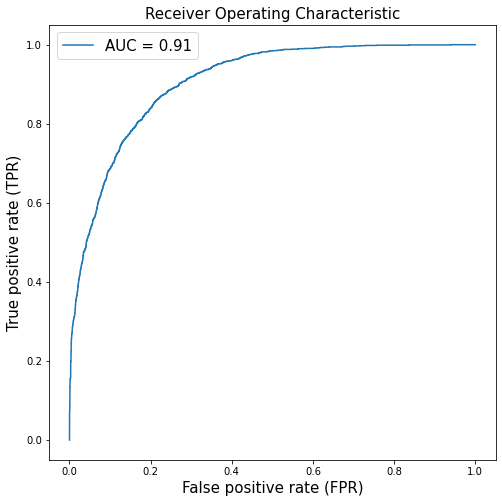

In [50]:
# Вычислить вероятности принадлежности классу 1 для каждого объекта из валидационной выборки
y_pred_proba = sigmoid(X_valid, theta)
calc_and_plot_roc(y_valid, y_pred_proba)

## 4. Добавление регуляризации

### 4.1. Оборачивание линейной регрессии в класс

In [59]:
class RegOptimizer():
    def __init__(self, alpha, n_iters):
        self.theta = None
        self._alpha = alpha
        self._n_iters = n_iters
    
    def gradient_step(self, theta, theta_grad):
        return theta - self._alpha * theta_grad
    
    def grad_func(self, X, y, theta):
        raise NotImplementedError()

    def optimize(self, X, y, start_theta, n_iters):
        theta = start_theta.copy()

        for _ in range(n_iters):
            theta_grad = self.grad_func(X, y, theta)
            theta = self.gradient_step(theta, theta_grad)

        return theta
    
    def fit(self, X, y):
        m = X.shape[1]
        start_theta = np.ones(m)
        self.theta = self.optimize(X, y, start_theta, self._n_iters)
        
    def predict(self, X):
        raise NotImplementedError()

In [60]:
class LinReg(RegOptimizer):
    def grad_func(self, X, y, theta):
        n = X.shape[0]
        grad = 1. / n * X.transpose().dot(X.dot(theta) - y)

        return grad
    
    def predict(self, X):
        if self.theta is None:
            raise Exception('You should train the model first')
        
        y_pred = X.dot(self.theta)
        
        return y_pred

In [61]:
def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f'MSE = {mse:.2f}, RMSE = {rmse:.2f}')
def prepare_boston_data():
    data = load_boston()
    X, y = data['data'], data['target']
    # Нормализовать даннные с помощью стандартной нормализации
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Добавить фиктивный столбец единиц (bias линейной модели)
    X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
    
    return X, y

In [62]:
linreg = LinReg(0.01, 500)
X, y = prepare_boston_data()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [63]:
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_valid)
print_regression_metrics(y_valid, y_pred)

MSE = 21.45, RMSE = 4.63


### 4.2. Оборачивание логистической регрессии в класс

In [64]:
class LogReg(RegOptimizer):
    def sigmoid(self, X, theta):
        return 1. / (1. + np.exp(-X.dot(theta)))
    
    def grad_func(self, X, y, theta):
        n = X.shape[0]
        grad = 1. / n * X.transpose().dot(self.sigmoid(X, theta) - y)

        return grad
    
    def predict_proba(self, X):
        return self.sigmoid(X, self.theta)
    
    def predict(self, X):
        if self.theta is None:
            raise Exception('You should train the model first')
        
        y_pred = self.predict_proba(X) > 0.5
        
        return y_pred

In [67]:
def prepare_adult_data():
    adult = pd.read_csv('./data/adult.data',
                        names=['age', 'workclass', 'fnlwgt', 'education',
                               'education-num', 'marital-status', 'occupation',
                               'relationship', 'race', 'sex', 'capital-gain',
                               'capital-loss', 'hours-per-week', 'native-country', 'salary'])
    
    # Избавиться от лишних признаков
    adult.drop(['native-country'], axis=1, inplace=True)
    # Сконвертировать целевой столбец в бинарные значения
    adult['salary'] = (adult['salary'] != ' <=50K').astype('int32')
    # Сделать one-hot encoding для некоторых признаков
    adult = pd.get_dummies(adult, columns=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex'])
    
    # Нормализовать нуждающиеся в этом признаки
    a_features = adult[['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']].values
    norm_features = (a_features - a_features.mean(axis=0)) / a_features.std(axis=0)
    adult.loc[:, ['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']] = norm_features
    
    # Разбить таблицу данных на матрицы X и y
    X = adult[list(set(adult.columns) - set(['salary']))].values
    y = adult['salary'].values

    # Добавить фиктивный столбец единиц (bias линейной модели)
    X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
    
    return X, y

In [68]:
logreg = LogReg(1., 300)
X, y = prepare_adult_data()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [69]:
# Разбить выборку на train/valid, оптимизировать theta,
# сделать предсказания и посчитать ошибку F1-score

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_valid)

print_logisitc_metrics(y_valid, y_pred)

acc = 0.85 F1-score = 0.66


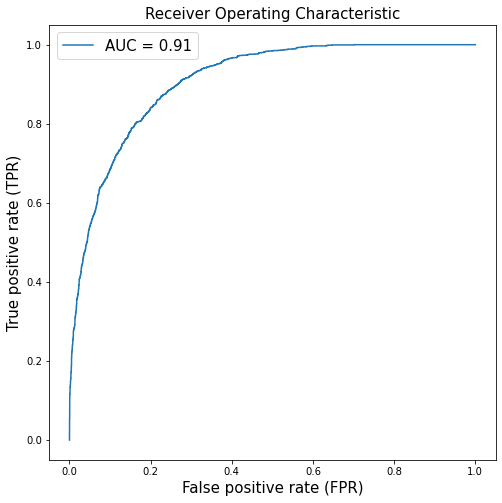

In [70]:
y_pred_proba = logreg.predict_proba(X_valid)
calc_and_plot_roc(y_valid, y_pred_proba)

В случаях линейной и логистической регрессии будем добавлять к функции ошибки регуляризующую часть как:
$$\frac{\lambda}{2m}\sum_{j}^{m}{\theta_j^2},$$
где $\theta$ — вектор параметров линейной модели без фиктивного признака (intercept/bias term), $m$ — количество нефиктивных признаков, $\lambda$ — параметр регуляризации.

### 4.3. Добавление регуляризатора в линейную регрессию

После добавления регуляризации функция ошибки линейной регрессии будет выглядеть следующим образом:
$$L=\frac{1}{2n} * \sum_{i=1}^{n}{(y_i - \theta^Tx_i)^2} + \frac{\lambda}{2m}\sum_{j}^{m}{\theta_j^2}$$
А ее градиент по параметру $\theta$:
$$\nabla L = \frac{1}{n}\sum_{i=1}^{n}{(\theta^Tx_i - y_i) \cdot x_i} + \frac{\lambda}{m}\sum_{j=1}^{m}{\theta_j} = \frac{1}{n}X^T(X\theta - y) + \frac{\lambda}{m}\sum_{j=1}^{m}{\theta_j}$$

In [71]:
class LinRegRegularized(LinReg):
    def __init__(self, alpha, lambd, n_iters):
        super(LinRegRegularized, self).__init__(alpha, n_iters)
        self._lambd = lambd
    
    def grad_func(self, X, y, theta):
        n = X.shape[0]
        grad = 1. / n * X.transpose().dot(X.dot(theta) - y)
        grad_term = self._lambd * np.mean(theta)

        return grad + grad_term

In [72]:
linreg = LinRegRegularized(alpha=0.01, lambd=0.05, n_iters=500)
X, y = prepare_boston_data()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [73]:
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_valid)
print_regression_metrics(y_valid, y_pred)

MSE = 32.15, RMSE = 5.67


### 4.4. Добавление регуляризатора в логистическую регрессию

Функция ошибки для логистической регрессии в случае бинарной классификации с регуляризатором записывается следующим образом:
$$L=-\frac{1}{n}(y_i \log h_{\theta}(x_i) + (1-y_i) \log(1-h_{\theta}(x_i)))+\frac{\lambda}{2m}\sum_{j}^{m}{\theta_j^2},$$
где $x_i$ — вектор признаков $i$-го примера из обучающей выборки, $y_i$ — истинный класс для соответствующего примера (0 или 1), $n$ — число примеров в обучающей выборке, $m$ — количество нефиктивных признаков, $\lambda$ — параметр регуляризации, $h_{\theta}(x)$ — sigmoid функция, равная:
$$h_{\theta}(x)=\frac{1}{1+\exp^{-\theta x}},$$
где $\theta$ — вектор параметров логистической регрессии, $x$ - вектор признаков объекта из выборки.

Соответствующий градиент функции ошибки равен:
$$\nabla L=\frac{1}{n}\sum_{i=1}^{n}{(h_{\theta}(x_i)-y_i)x_i}+\frac{\lambda}{m}\sum_{j}^{m}{\theta_j}$$

In [98]:
class LogRegRegularized(LogReg):
    def __init__(self, alpha, lambd, n_iters):
        super(LogRegRegularized, self).__init__(alpha, n_iters)
        self._lambd = lambd
    
    def grad_func(self, X, y, theta):
        n = X.shape[0]
        grad = 1. / n * X.transpose().dot(self.sigmoid(X, theta) - y)
        grad_term = self._lambd * np.mean(theta)

        return grad + grad_term

In [99]:
for i in np.arange(0.0, 1.0, 0.01):
    logreg = LogRegRegularized(alpha=1., lambd=1., n_iters=300)
    X, y = prepare_adult_data()
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_valid)
    print(i)
    print_logisitc_metrics(y_valid, y_pred)

0.0
acc = 0.85 F1-score = 0.65
0.01
acc = 0.85 F1-score = 0.65
0.02
acc = 0.85 F1-score = 0.65
0.03
acc = 0.86 F1-score = 0.67
0.04
acc = 0.85 F1-score = 0.67
0.05
acc = 0.85 F1-score = 0.66
0.06
acc = 0.84 F1-score = 0.65
0.07
acc = 0.86 F1-score = 0.66
0.08
acc = 0.85 F1-score = 0.65
0.09
acc = 0.85 F1-score = 0.66
0.1
acc = 0.85 F1-score = 0.67
0.11
acc = 0.85 F1-score = 0.66
0.12
acc = 0.85 F1-score = 0.65
0.13
acc = 0.85 F1-score = 0.66
0.14
acc = 0.86 F1-score = 0.67
0.15
acc = 0.85 F1-score = 0.64
0.16
acc = 0.86 F1-score = 0.66
0.17
acc = 0.84 F1-score = 0.65
0.18
acc = 0.86 F1-score = 0.67
0.19
acc = 0.85 F1-score = 0.64
0.2
acc = 0.85 F1-score = 0.66
0.21
acc = 0.85 F1-score = 0.66
0.22
acc = 0.85 F1-score = 0.65
0.23
acc = 0.85 F1-score = 0.67
0.24
acc = 0.85 F1-score = 0.65
0.25
acc = 0.86 F1-score = 0.67
0.26
acc = 0.85 F1-score = 0.65
0.27
acc = 0.85 F1-score = 0.64
0.28
acc = 0.85 F1-score = 0.65
0.29
acc = 0.85 F1-score = 0.65
0.3
acc = 0.85 F1-score = 0.64
0.31
acc = 0

In [75]:
logreg = LogRegRegularized(alpha=1., lambd=1., n_iters=300)
X, y = prepare_adult_data()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [76]:
# Разбить выборку на train/valid, оптимизировать theta,
# сделать предсказания и посчитать ошибку F1-score

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_valid)

print_logisitc_metrics(y_valid, y_pred)

acc = 0.85 F1-score = 0.66


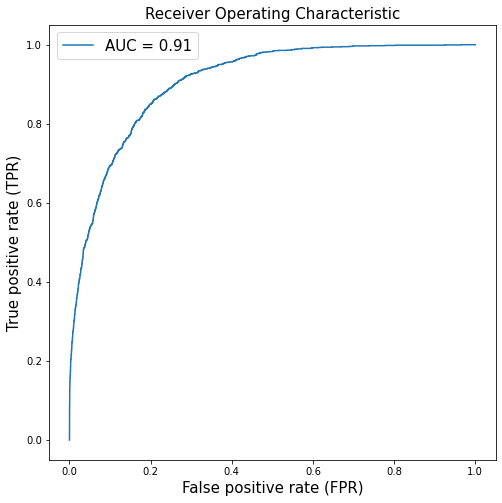

In [77]:
y_pred_proba = logreg.predict_proba(X_valid)
calc_and_plot_roc(y_valid, y_pred_proba)